Fútbol Match Highlights<br>
Face vs Object Model - Capstone 2<br>
Tom Widdows

This notebook trains and saves a model that can distinguish between faces and objects (non-faces). <br><br>
Face detection is the process of identifying faces in an image.  Face recognition is the process of recognizing a face that was detected.  During the process of face detection, the detector will often incorrectly identify objects (non-faces) as faces.  The images below show 4 **"faces"** detected from images.

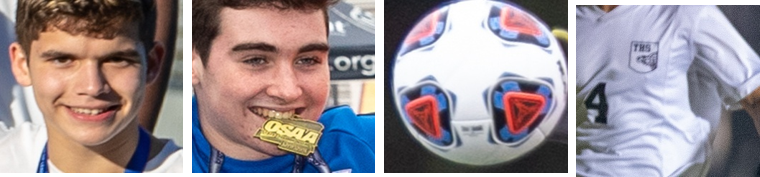

The main application loads this model and verifies that detected faces in the current image are not objects (non-faces) before attempting facial recognition.  This notebooks purpose is to train and save a model for later use in the main application.

##### Housekeeping...

In [1]:
#import required modules
import sys
sys.path.append('../code')
import settings as s

import cv2
from lightgbm import LGBMClassifier
import numpy as np 
import pandas as pd 
from pathlib import Path
import pickle
import random
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from support_class import Fball, time_it
import time

start_all = time.time()  # track time for notebook to run
%matplotlib inline

Using TensorFlow backend.


##### Common variables and settings...

In [2]:
# variables used throughout the notebook
random.seed(14)
vec_size = 64  # pixel width & height (square) of training vector, vec is vec_size * vec_size

# save figure unique filenames
cm_valid_fig = Fball.checkfile('08 - 02 Extended Face vs Object Model CM Valid.jpg', ir=False)
cm_test_fig = Fball.checkfile('08 - 02 Extended Face vs Object Model CM Test.jpg', ir=False)

# classifiers
classification_algos_name = [
    "KNeighborsClassifier",
    "GaussianNB",
    "DecisionTreeClassifier",
    "ExtraTreeClassifier",
    "LGBMClassifier"
]

classification_algos = [
    KNeighborsClassifier(20),
    GaussianNB(),
    DecisionTreeClassifier(),
    ExtraTreeClassifier(),
    LGBMClassifier()
]

#### Load our two datasets

In [3]:
faces = [f for f in Path(s.FACE_VS_OBJECT_DATASET / 'extended_faces').iterdir()]
no_faces = [f for f in Path(s.FACE_VS_OBJECT_DATASET / 'extended_objects').iterdir()]
Fball.count_summary([faces, no_faces], ['images with faces', 'images with objects (no_faces)', 'total images'])

  712 images with faces
  488 images with objects (no_faces)
1,200 total images


#### Read the images in each set, convert to grayscale and resize 

In [4]:
# feature engineering for faces - read image, convert to grayscale and resize
faces_vecs = []
for face in faces:
    image = cv2.imread(str(face), cv2.IMREAD_GRAYSCALE)
    vec = cv2.resize(image, (vec_size, vec_size)).flatten()
    faces_vecs.append(vec)

In [5]:
# feature engineering for objects (non-faces) - read image, convert to grayscale and resize
no_faces_vecs = []
for no_face in no_faces:
    image = cv2.imread(str(no_face), cv2.IMREAD_GRAYSCALE)
    vec = cv2.resize(image, (vec_size, vec_size)).flatten()
    no_faces_vecs.append(vec)

#### Combine the data

In [6]:
df = pd.DataFrame()
df = df.append(faces_vecs)
df = df.append(no_faces_vecs)
feature_names = list(range(vec_size**2))
df.columns = feature_names

##### Scale and split the data

In [7]:
# prepare and split the data
X = df
y = np.concatenate((np.ones(len(faces_vecs)), np.zeros(len(no_faces_vecs))))

scaler = StandardScaler().fit(X)
X = pd.DataFrame(scaler.transform(X))
X.columns = feature_names

X_train, y_train, X_valid, y_valid, X_test, y_test, X_train_and_valid, y_train_and_valid = Fball.train_valid_test(X, y, hyperopt_train_set=False)


Total Data:                   1,200  100%  X

Test (holdout) data:            120   10%  X_test
Train and Validation data:    1,080   90%  X_train_and_valid

Train data:                     864   72%  X_train
Validation data:                216   18%  X_valid



##### Run classifiers, compare performance and choose best classifier

In [8]:
# run the classifiers

start = time.time()
accuracy_score_list = []
f1_score_list = []
precision_score_list = []
recall_score_list = []
roc_auc_score_list = []
models = []

print(f'\n{"classsifier":<30} {"accuracy":<6}  {"f1_score":<6}  {"precision":<7}    {"recall":<6}   {"roc_auc":<6}  {"time":<15}')

for idx, mod in enumerate(classification_algos):
    start = time.time()
    model = mod
    model.fit(X_train, y_train)
    y_valid_pred = model.predict(X_valid)
    end = time.time()
    recall_score_list.append(recall_score(y_valid, y_valid_pred))
    precision_score_list.append(precision_score(y_valid, y_valid_pred))
    f1_score_list.append(f1_score(y_valid, y_valid_pred))
    accuracy_score_list.append(accuracy_score(y_valid, y_valid_pred))
    roc_auc_score_list.append(roc_auc_score(y_valid, y_valid_pred))

    print(f"{classification_algos_name[idx]:<30} {accuracy_score_list[idx]:>8.2%}  {f1_score_list[idx]:>8.2%}  {precision_score_list[idx]:>9.2%}  {recall_score_list[idx]:>8.2%}  {roc_auc_score_list[idx]:>8.2%}  {end-start:.2f} sec")
Fball.bl()    


classsifier                    accuracy  f1_score  precision    recall   roc_auc  time           
KNeighborsClassifier             86.57%    87.97%     93.81%    82.81%    87.43%  1.83 sec
GaussianNB                       81.94%    84.46%     86.18%    82.81%    81.75%  0.16 sec
DecisionTreeClassifier           74.54%    78.76%     77.86%    79.69%    73.37%  1.53 sec
ExtraTreeClassifier              79.17%    82.07%     83.74%    80.47%    78.87%  0.03 sec
LGBMClassifier                   89.81%    91.13%     94.17%    88.28%    90.16%  5.98 sec



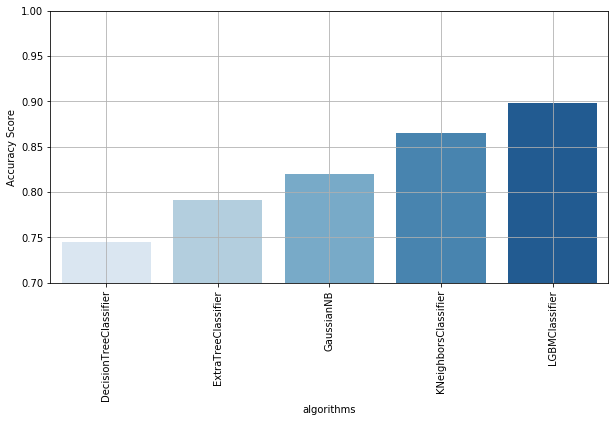

Best classifier: LGBMClassifier

Selecting LGBMClassifier
   LGBMClassifier has features_importances_
   LGBMClassifier does NOT has coef_

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)



In [9]:
# visually compare the classifiers
model_best_roc = Fball.plot_model_comparison(classification_algos_name, accuracy_score_list, [.7,1])
model = Fball.get_model_info(classification_algos, model_best_roc, classification_algos_name, X_train, y_train, show_feat_imp=False)

##### Train the best classifier on the train data and predict on the validation data

The baseline score (roc_auc) on the validation set is 96.65%



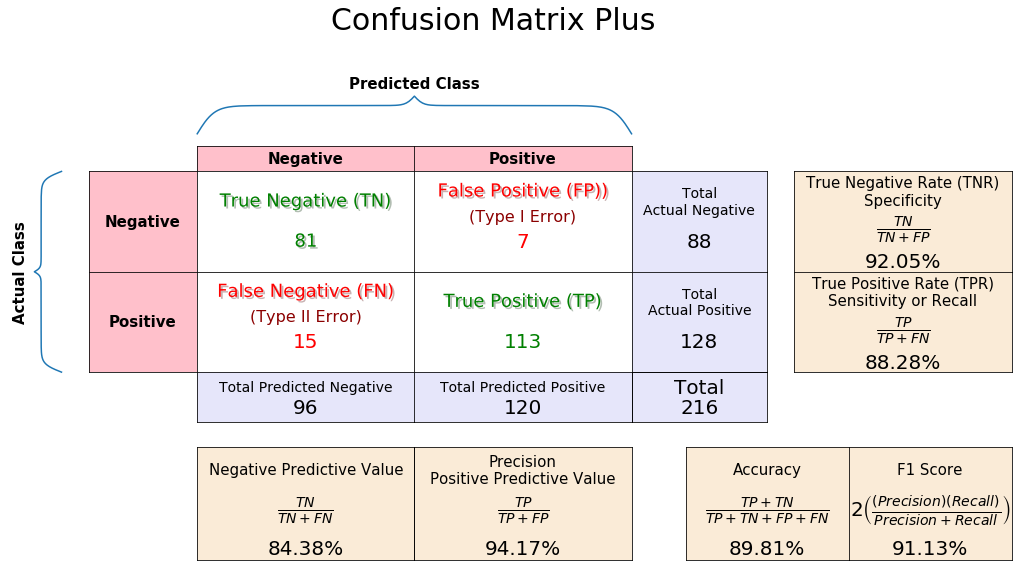


The kappa score is 79.20%

The MCC score is 79.43%

00:00:06


In [10]:
y_pred_prob = Fball.eval_model_valid(model, X_train, y_train, X_valid, y_valid, print_kappa=True, print_mcc=True)

##### Review the Confusion Matrix at cutoffs from 1 to 100

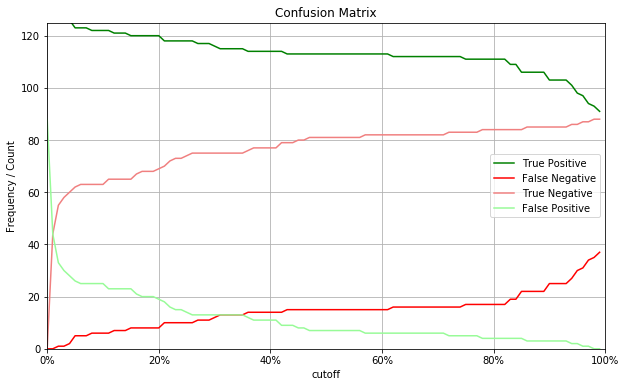

In [11]:
df_cutoff = Fball.graph_cutoff(y_pred_prob, y_valid)

##### Choose a cutoff based on the above plot and reevaluate using plots and confusion matrix below

In [12]:
_cutoff = 42

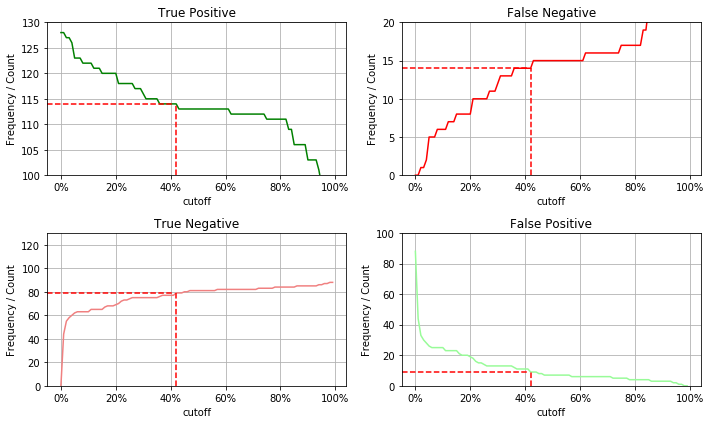

In [13]:
y_limits = [(100, 130), (0, 20), (0, 130), (0, 100)]
Fball.exploded_cm(df_cutoff, _cutoff, y_limits)

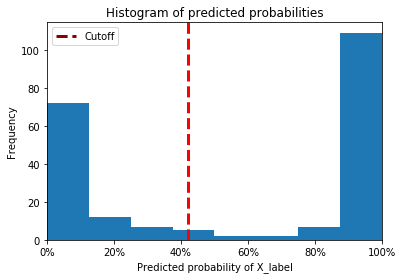

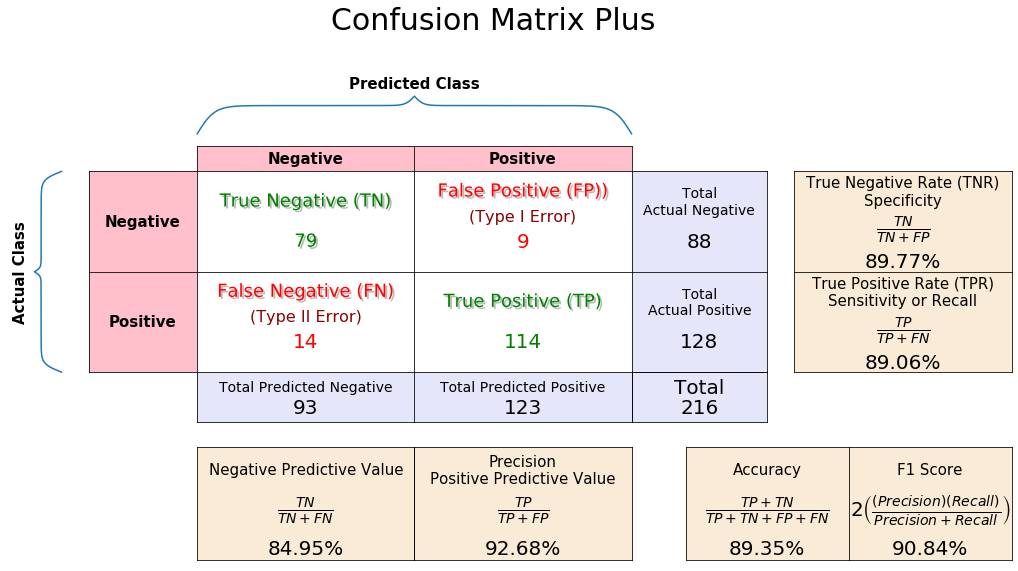

The kappa score is 79.20%
The MCC score is 79.43%



In [14]:
cutoff = Fball.cm_after_cutoff(_cutoff, y_pred_prob, X_valid, y_valid, print_kappa=True, print_mcc=True, save_fig=cm_valid_fig)

##### Retrain model on train and validation data and predict on test (holdout) data

The baseline score (roc_auc) on the validation set is 96.84%



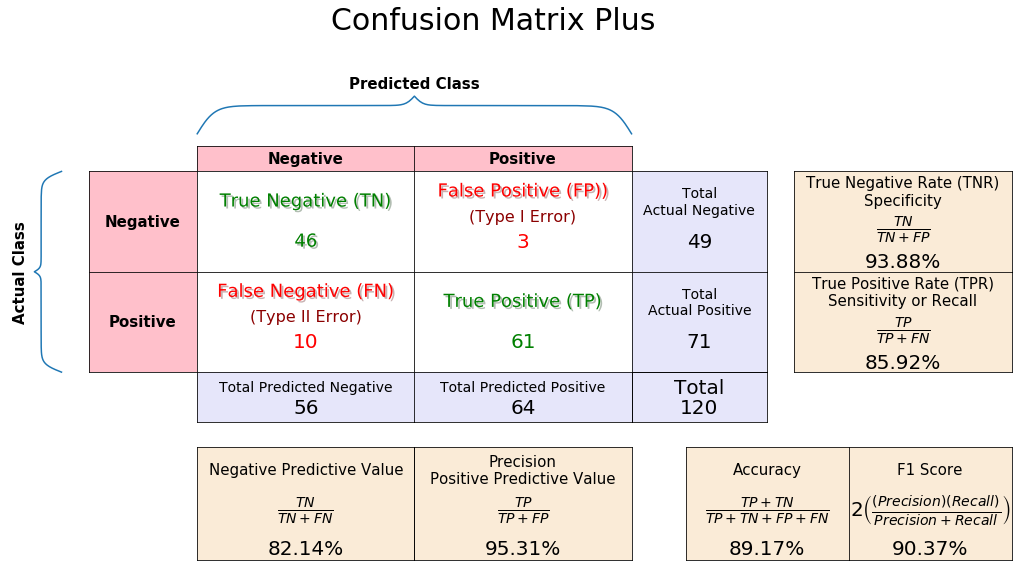


The kappa score is 78.07%

The MCC score is 78.62%

00:00:08


In [15]:
y_pred_prob = Fball.eval_model_valid(model, X_train_and_valid, y_train_and_valid, X_test, y_test, print_kappa=True, print_mcc=True, save_fig=cm_test_fig)

##### Save the model

In [16]:
# save the model to disk
Fball.save_model(model, 'extended_face_vs_object_model', ir=False)
Fball.save_model(scaler, 'extended_face_vs_object_scaler', ir=False)

In [17]:
print(f'{time.strftime("%H:%M:%S", time.gmtime(int(time.time() - start_all)))}')

00:00:38
